# **NLP Project: Analyzing and Predicting Salary from Job Description**

*Master in Machine Learning for Health, 2023~2024*

*Authors: Daniel Corrales, Jaime Fernández & Rafael Rodríguez*

---

In [1]:
# Common imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as scsp
import networkx as nx
import subprocess
import pickle
import warnings
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#To wrap long text lines
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [5]:
# For fancy table Display
%load_ext google.colab.data_table

In [6]:
import spacy
import gensim
print(spacy.__version__)

3.7.4


In [ ]:
# Download spaCy model
!python -m spacy download en_core_web_md # Or other

## **0. Data Loading**

In [8]:
path = '/content/drive/MyDrive/NLP/Project'
df_jobs = pd.read_csv(path + '/processed/jobs_processed.csv')

We work with the `full_info` column as input data and the `avg_pay` column as target column.

In [9]:
corpus = df_jobs['full_info'].to_list()
avg_pay = df_jobs['avg_pay'].to_list()

print(f"Number of job offers: {len(corpus)}")

Number of job offers: 2270


Let's print an example to chechk everything is working properly.

In [10]:
idx = 1000
print(f"Average pay: {avg_pay[idx]}\n")
print(corpus[idx])

Average pay: 62400.0

Job title: Temporary Language Consultant. Company name: University of Kansas.                                         Location: Strong Hall, 1450 Jayhawk Blvd, Room 230, Lawrence, KS 66045. Job type: Temporary. Position Overview
The Department of Linguistics at the University of Kansas seeks to hire a part-time Me’phaa language consultant. Hours are flexible, and remote work is possible. The language consultant position is a collaborative position working in conjunction with a member of the department (and possibly additional consultants) to create materials that support Me’phaa language documentation and teaching.
 Job Description
Identifying words, phrases, and other aspects of Me’phaa language and culture that will be important for language documentation and pedagogical work (20%)
Creating audio and video recordings (60%)
 Helping create digital language resources (10%)
Data organization (5%)
Participating in team meetings (5%)
Position Requirements
Hybird
Requ

In [11]:
with open(path + '/vectorizations/bow_corpus.pkl', 'rb') as f:
    corpus_bow_dense = pickle.load(f)

with open(path + '/vectorizations/tfidf_corpus.pkl', 'rb') as f:
    corpus_tfidf_dense = pickle.load(f)

with open(path + '/vectorizations/lemmatized_corpus.pkl', 'rb') as f:
    lemmatized_corpus = pickle.load(f)

with open(path + '/vectorizations/ngram_corpus.pkl', 'rb') as f:
    n_gram_corpus = pickle.load(f)

with open(path + '/vectorizations/lda_corpus.pkl', 'rb') as f:
    LDA_corpus = pickle.load(f)

# with open(path + '/vectorizations/wordemb_corpus.pkl', 'rb') as f:
#     wemb_corpus = pickle.load(f)

## **1. Preprocessing Pipeline**

Here we preprocess the corpus to obtain its lemmatized version and we perform N-gram detection.

In [ ]:
nlp = spacy.load('en_core_web_md')
nlp.disable_pipe('parser')
nlp.disable_pipe('ner')

# Corpus list contains all documents (train, val and test)
lemmatized_corpus = [[tk.lemma_ for tk in nlp(doc.lower()) if (tk.is_alpha or tk.is_digit) \
                      and not tk.is_stop and not tk.is_punct] for doc in corpus]

avg_length = np.mean([len(lemmas) for lemmas in lemmatized_corpus])
print(f"Average number of lemmas per job offer: {avg_length}\n")
print(lemmatized_corpus[0])

Average number of lemmas per job offer: 461.32775330396476

['job', 'title', 'electrical', 'engineering', 'opportunity', 'university', 'graduate', 'company', 'microsoft', 'location', 'microsoft', 'way', 'redmond', 'wa', '98052', 'job', 'type', 'time', 'come', 'build', 'community', 'explore', 'passion', 'good', 'work', 'microsoft', 'thousand', 'university', 'student', 'corner', 'world', 'opportunity', 'allow', 'bring', 'aspiration', 'talent', 'potential', 'excitement', 'journey', 'ahead', 'electrical', 'engineer', 'microsoft', 'design', 'develop', 'modify', 'evaluate', 'component', 'electronic', 'device', 'involve', 'manipulation', 'transmission', 'storage', 'electricity', 'define', 'design', 'approach', 'implementation', 'schedule', 'technical', 'specification', 'parameter', 'device', 'partake', 'select', 'material', 'component', 'base', 'analysis', 'specification', 'reliability', 'opportunity', 'allow', 'develop', 'test', 'plan', 'direct', 'support', 'personnel', 'engineer', 'preparat

### N-gram Detection

In [ ]:
# Firts step is to find N-grams to improve LDA's performance
n_gram_model = gensim.models.phrases.Phrases(lemmatized_corpus, min_count=30, threshold=20)
n_gram_corpus = [el for el in n_gram_model[lemmatized_corpus]]

# Display table with N-grams
n_gram_dict = {}
detected_n_grams = []

for doc in n_gram_corpus:
  for word in doc:
    if '_' in word:
      if word not in detected_n_grams:
        detected_n_grams.append(word)
        n_gram_dict[word] = 0

      n_gram_dict[word] += 1

n_grams_df = pd.DataFrame([(key, value) for key, value in n_gram_dict.items()], columns=['N_gram', 'Count']).sort_values(by='Count', ascending=False)
n_grams_df

,N_gram,Count
0,job_title,2360
4,job_type,2338
254,human_resource,1854
18,equal_opportunity,1283
31,national_origin,901
...,...,...
680,applicant_criminal,2
537,ordinance_need,1
689,accrediting_institution,1
408,98052_job,1


Save the lemmatized corpus and N-gram corpus.

In [ ]:
with open(path + '/vectorizations/lemmatized_corpus.pkl', 'wb') as f:
  pickle.dump(lemmatized_corpus, f)

with open(path + '/vectorizations/ngram_corpus.pkl', 'wb') as f:
  pickle.dump(n_gram_corpus, f)

## **2. Vectorization**

Three main vectorizations are generated here: BoW, TF-IDF and word embeddings.

In [ ]:
D = gensim.corpora.Dictionary(n_gram_corpus)
len_bf = len(D)

D.filter_extremes(no_below=4, no_above=0.8, keep_n=7500)
len_af = len(D)

print(f"Dictionary length before filtering: {len_bf}")
print(f"Dictionary length after filtering: {len_af}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dictionary length before filtering: 20080
Dictionary length after filtering: 7500


### Bag of Words

In [ ]:
corpus_bow_sparse = [D.doc2bow(doc) for doc in n_gram_corpus]
corpus_bow_dense = gensim.matutils.corpus2dense(corpus_bow_sparse, num_terms=len(D)).T
print(corpus_bow_dense.shape)

### TF-IDF

In [ ]:
tfidf = gensim.models.TfidfModel(corpus_bow_sparse)
corpus_tfidf_sparse = tfidf[corpus_bow_sparse]
corpus_tfidf_dense = gensim.matutils.corpus2dense(corpus_tfidf_sparse, num_terms=len(D)).T
print(corpus_tfidf_dense.shape)

(2270, 7500)


### Word Embeddings

In [ ]:
wemb_corpus = [[tk.vector for tk in nlp(doc)] for doc in corpus] # No preprocessing pipeline
avg_wemb = np.mean([len(wemb) for wemb in wemb_corpus])

print(f"Average number of words per doc: {avg_wemb}")
print(len(wemb_corpus))

Average number of words per doc: 903.8251101321586
2270


Save vectorizations for later on.

In [ ]:
with open(path + '/vectorizations/bow_corpus.pkl', 'wb') as f:
  pickle.dump(corpus_bow_dense, f)

with open(path + '/vectorizations/tfidf_corpus.pkl', 'wb') as f:
  pickle.dump(corpus_tfidf_dense, f)

with open(path + '/vectorizations/wordemb_corpus.pkl', 'wb') as f:
  pickle.dump(wemb_corpus, f)

## **3. Topic Modeling: Latent Dirichlet Allocation**

Latent Dirichlet Allocation is peformed to analyze the sematic structuture of the corpus in terms of topics and to obtain the LDA document vectorization.

### Latent Dirichlet Allocation with Mallet

In [ ]:
def install_java():
    !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
    !java -version
install_java()

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [20]:
os.environ['MALLET_HOME'] = 'mallet-2.0.8'
mallet_path = 'mallet-2.0.8/bin/mallet'

Import corpus to *.txt file.

In [21]:
with open('n_gram_corpus.txt', 'w') as f:
  for i, doc in enumerate(n_gram_corpus):
    text = " ".join(doc)
    f.write(f"{i} 0 {text}\n")
  f.close()

!mallet-2.0.8/bin/mallet import-file --input n_gram_corpus.txt --output mycorpus.mallet --keep-sequence --remove-stopwords

Analyze coherence for different number of topics.

In [22]:
def compute_mallet_LDA(n_topics, corpus, coherence=True, verbose=True):
  # Train LDA
  if verbose:
    print(f"Mallet LDA n_topics {n_topics}")

  command = f"mallet-2.0.8/bin/mallet train-topics --input mycorpus.mallet --num-topics {n_topics} --num-iterations 1000 \
              --output-doc-topics doc_topics.txt --word-topic-counts-file wtc_counts.txt --topic-word-weights-file \
              topic_weights.txt --output-topic-keys topic_keys.txt --num-top-words 20"
  subprocess.call(command, shell=True)

  # Retrieve doc-topics matrix and sparsify
  thetas = []
  with open('doc_topics.txt', 'r') as f:
    doc_topic = f.readlines()
    f.close()

  for line in doc_topic:
    digits = line.split("\t")[2:]
    thetas.append(np.array([float(dig) for dig in digits]))

  thetas = np.vstack(thetas)
  thetas = np.where(thetas < 0.01, 0, thetas)
  thetas = [[(i, prob) for i, prob in enumerate(doc) if prob != 0.0] for doc in thetas]

  # Create corpus and dictionary in Mallet format
  with open("topic_keys.txt") as fin:
    tpc_descriptions = fin.readlines()
    tpc_descriptions = [el.strip().split("\t")[-1].split() for el in tpc_descriptions]

  Dict = gensim.corpora.Dictionary(corpus)

  # Compute coherence
  if coherence:
    n_words = 20
    cm =  gensim.models.coherencemodel.CoherenceModel(topics=tpc_descriptions, texts=corpus, dictionary=Dict, coherence='c_v', topn=n_words)
    coherence = np.mean(cm.get_coherence_per_topic())
    return thetas, tpc_descriptions, Dict, coherence

  return thetas, tpc_descriptions, Dict

In [ ]:
n_topics = np.arange(5, 55, 5)
coherence_list_mallet = []

for n in n_topics:
  _, _, _, coherence = compute_mallet_LDA(n, corpus=n_gram_corpus, coherence=True)
  coherence_list_mallet.append(coherence)

Mallet LDA n_topics 5
Mallet LDA n_topics 10
Mallet LDA n_topics 15
Mallet LDA n_topics 20
Mallet LDA n_topics 25
Mallet LDA n_topics 30
Mallet LDA n_topics 35
Mallet LDA n_topics 40
Mallet LDA n_topics 45
Mallet LDA n_topics 50


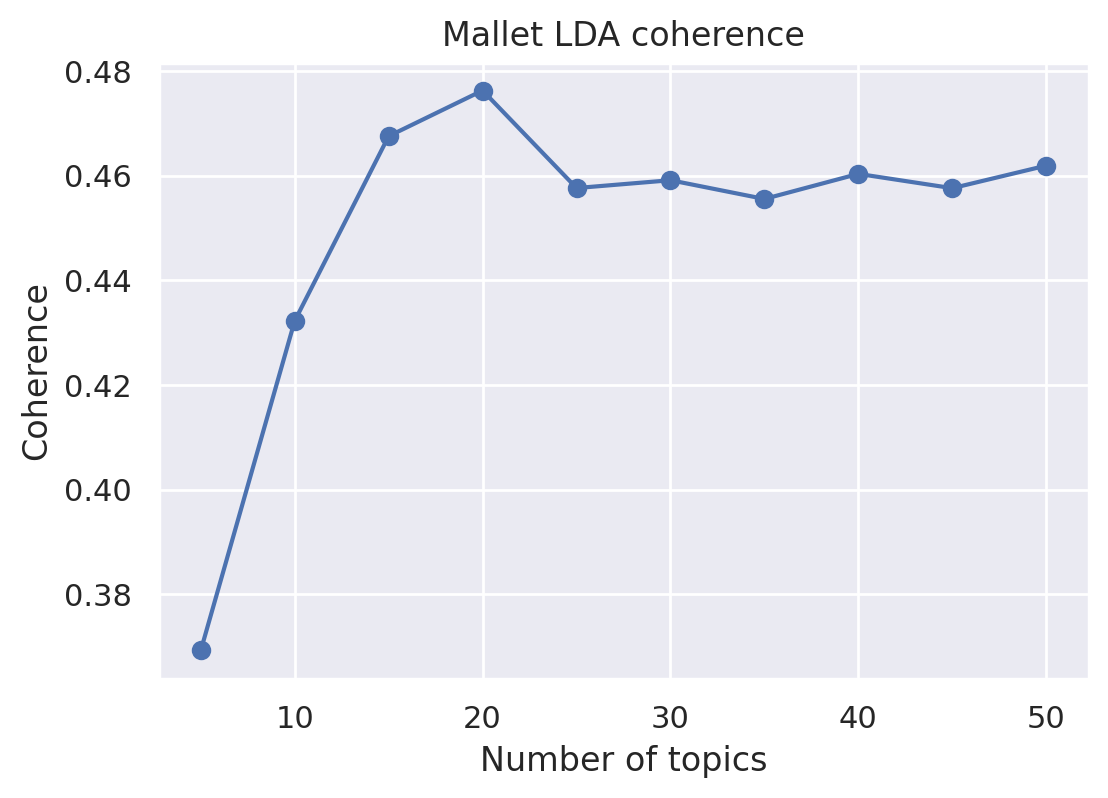

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(n_topics, coherence_list_mallet, label='Mallet', marker='o')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Mallet LDA coherence')
plt.show()

Retrain the model with highest coherence.

In [23]:
idx_max = np.argmax(coherence_list_mallet)
best_n_topics = n_topics[idx_max]

LDA_corpus, tpc_descriptions, Dict = compute_mallet_LDA(best_n_topics, corpus=n_gram_corpus, coherence=False) # LDA_corpus contains the vectorization

Mallet LDA n_topics 20


Save LDA embedding.

In [24]:
with open(path + '/vectorizations/lda_corpus.pkl', 'wb') as f:
  pickle.dump(LDA_corpus, f)

### Visualization and Analysis

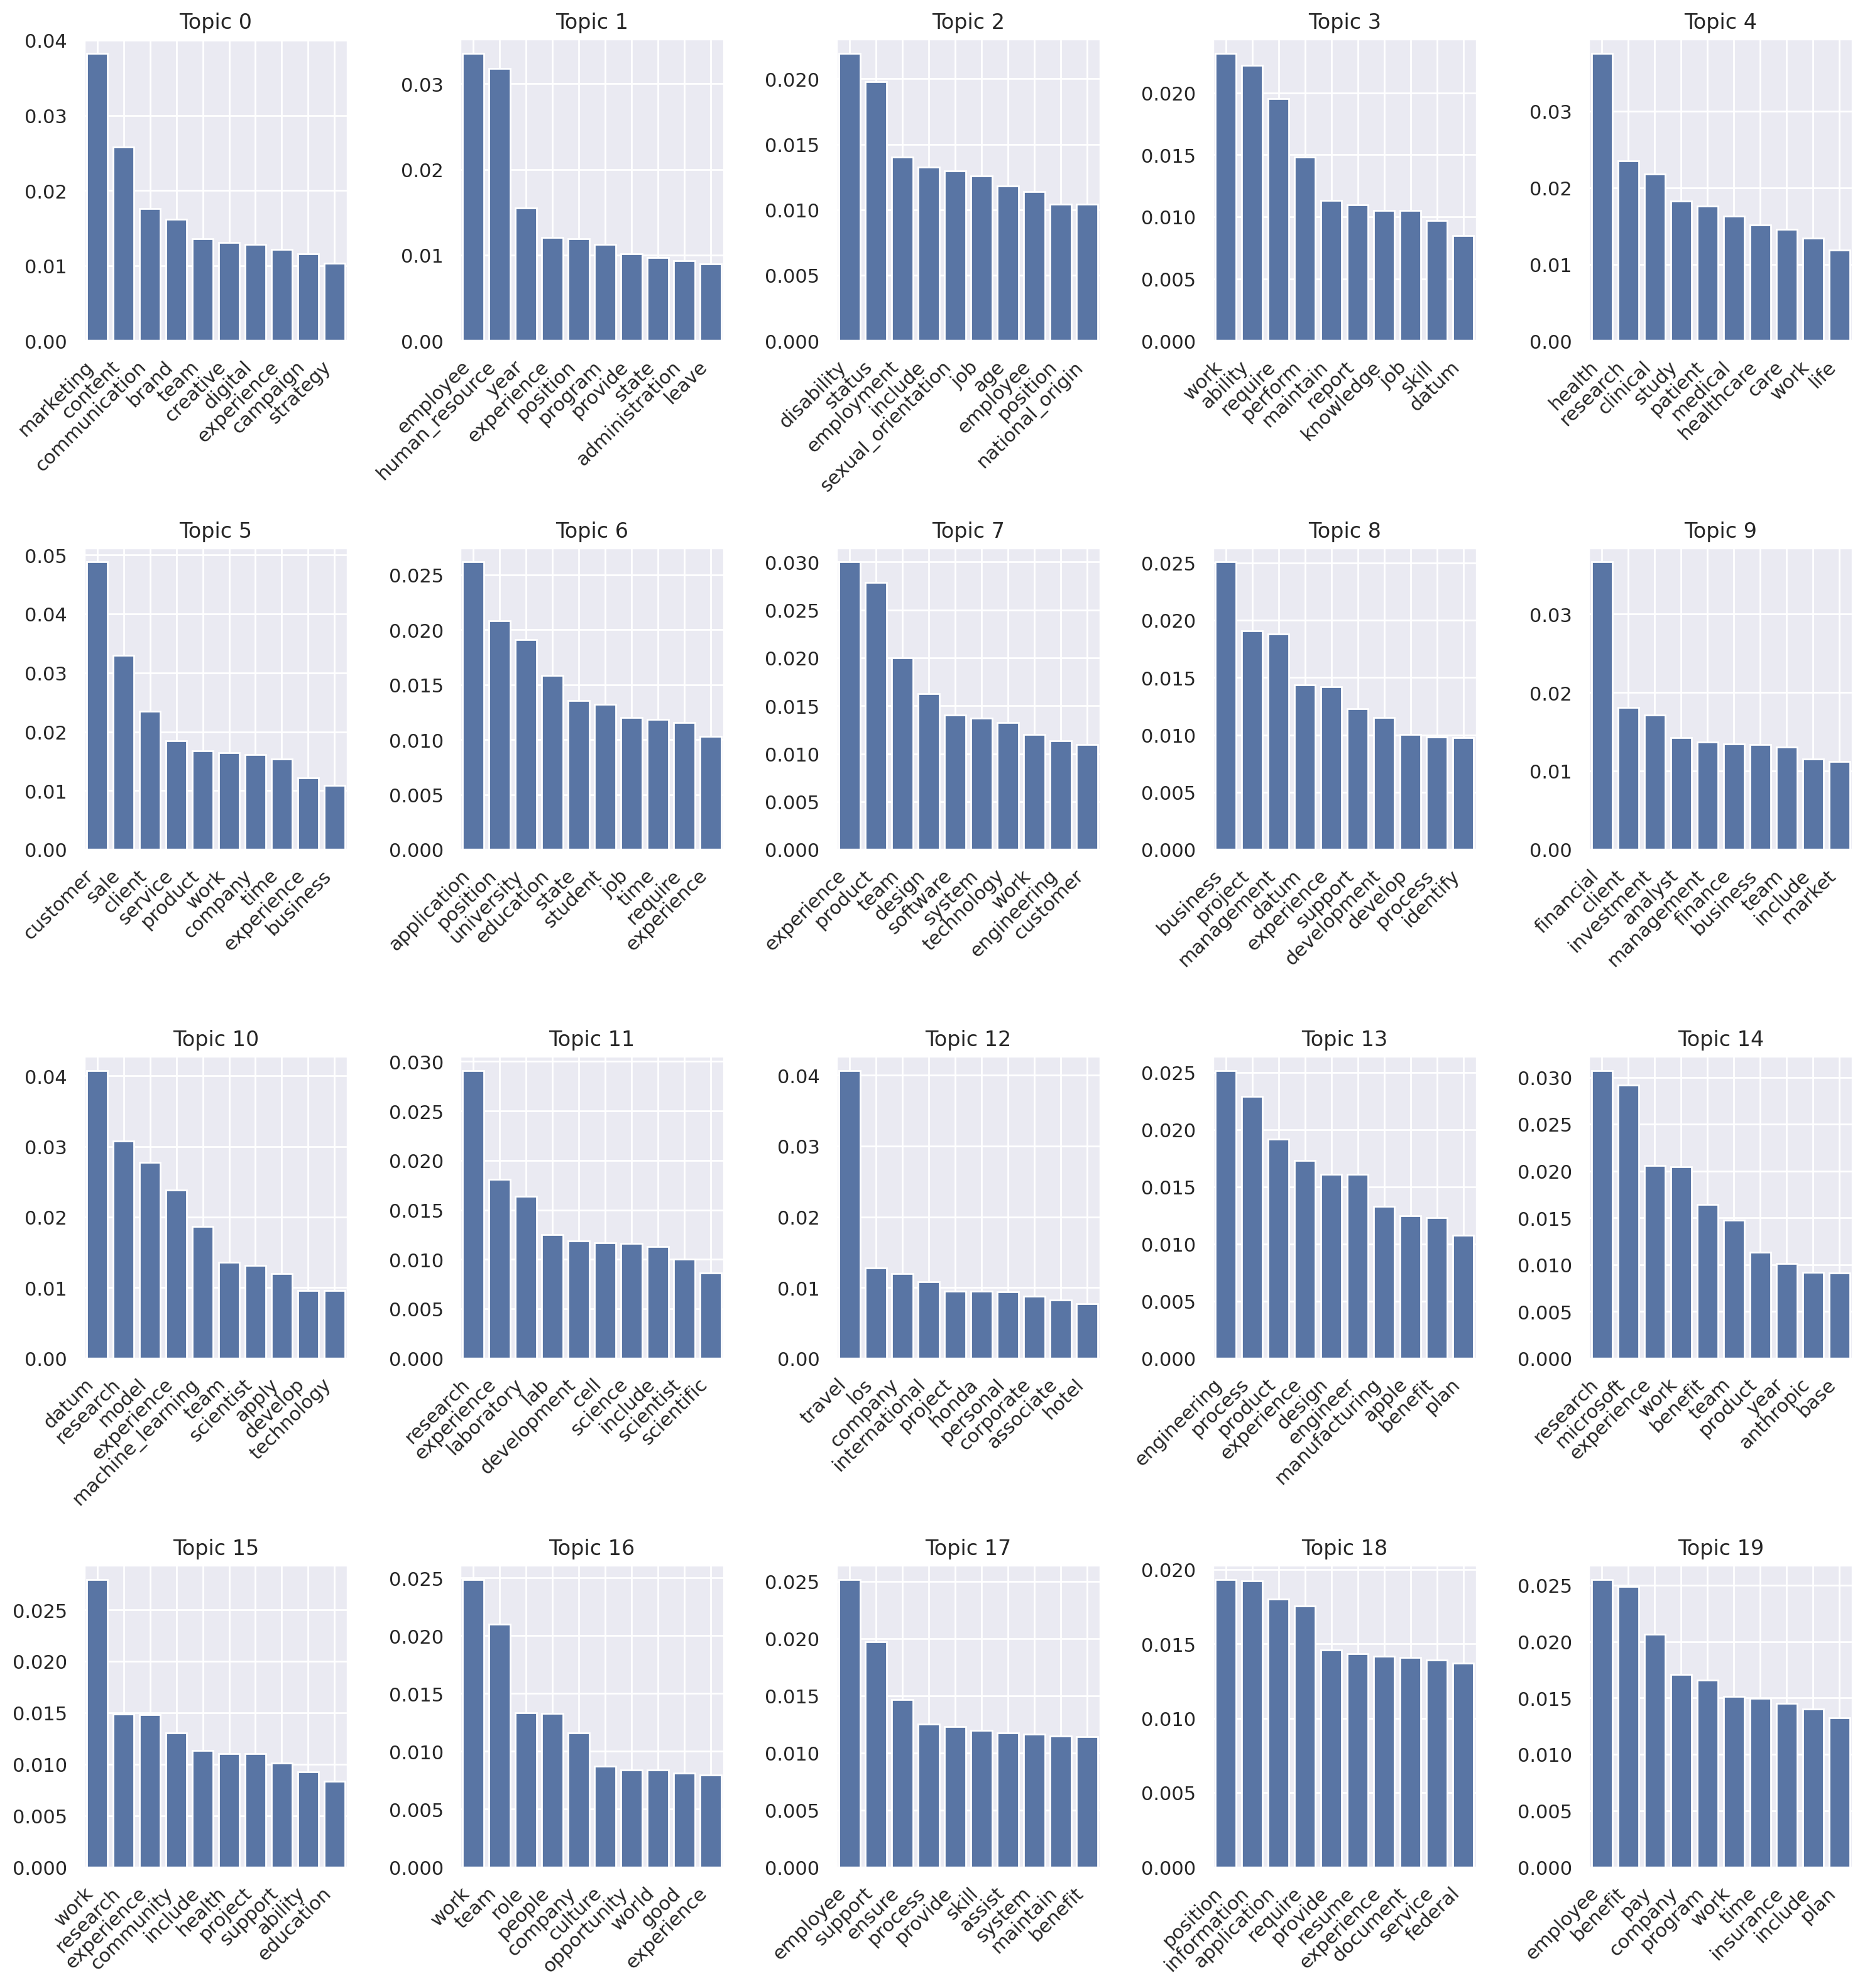

In [25]:
from matplotlib.ticker import FixedLocator

# Read topic-weights file
topic_weights_df = pd.read_csv("topic_weights.txt", sep='\t', header=None, names=["Topic", "Token", "Weight"])

# Normalize weights for each topic
topic_weights_df['Weight'] = topic_weights_df.groupby('Topic')['Weight'].transform(lambda x: x / x.sum())

# Function to extract top N tokens for each topic based on weights
def get_top_tokens(row, n=10):
    return row.sort_values(by='Weight', ascending=False).head(n)

# Apply the function to create a new DataFrame with top 10 tokens for each topic
top_tokens_df = topic_weights_df.groupby('Topic').apply(get_top_tokens).reset_index(drop=True)

# Plot bar plot for each topic
topics = top_tokens_df['Topic'].unique()
num_topics = len(topics)
num_cols = 5
num_rows = -(-num_topics // num_cols)  # Ceiling division to get the number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4*num_rows), layout='tight')

for i, topic in enumerate(topics):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]

    topic_data = top_tokens_df[top_tokens_df['Topic'] == topic]
    sns.barplot(x='Token', y='Weight', data=topic_data, ax=ax)
    ax.set_title(f"Topic {topic}")
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(True)

    num_tokens = len(topic_data)
    ax.xaxis.set_major_locator(FixedLocator(range(num_tokens)))

# Hide empty subplots if necessary
if num_rows * num_cols > num_topics:
    for i in range(num_topics, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## **4. Supervised Learning Task**

In [ ]:
# TODO

### Transformers

In [ ]:
# TODO

## **5. Semantic Graph and Distances between Documents**

Convert to sparse matrix representation.

In [38]:
with open(path + '/vectorizations/lda_corpus.pkl', 'rb') as f:
    LDA_corpus = pickle.load(f)

In [39]:
# Convert from list of tuples to sparse matrix
LDA_sparse = gensim.matutils.corpus2csc(LDA_corpus).T
n_topics = LDA_sparse.shape[1]
n_docs = LDA_sparse.shape[0]

print(f"Number of topics: {n_topics}")
print(f"X: sparse matrix with {LDA_sparse.nnz} nonzero values out of {n_docs * n_topics}")
print(LDA_sparse.shape)

Number of topics: 20
X: sparse matrix with 18922 nonzero values out of 45400
(2270, 20)


Renormalize rows to get probabilistic embeddings.

In [40]:
print(f"Average row sum before normalizing: {np.mean(LDA_sparse.sum(axis=1).T)}")

LDA_sparse = scsp.csr_matrix(LDA_sparse / np.sum(LDA_sparse, axis=1))

print(f"Average row sum after normalizing: {np.mean(LDA_sparse.sum(axis=1).T)}")

Average row sum before normalizing: 0.9756703687172911
Average row sum after normalizing: 1.0


Compute Similarity matrix based on Battacharyya Coefficient.

In [41]:
S = np.sqrt(LDA_sparse) * np.sqrt(LDA_sparse.T)

print(f"Shape of S: {S.shape}")
print(f"Number of non-zero elements: {S.nnz}")
print(f"Proportion of non-zero values: {S.nnz / (S.shape[0] * S.shape[1]) * 100:.3f}%")

Shape of S: (2270, 2270)
Number of non-zero elements: 5084144
Proportion of non-zero values: 98.666%


In [42]:
S = scsp.triu(S, k=1) # Mantain upper triangular matrix
print('Number of non-zero components in S:', S.nnz)

Number of non-zero components in S: 2540937


Threshold similarity matrix to discard non important edges.

In [43]:
n_nodes = LDA_sparse.shape[0]
n_edges = S.nnz
n_edges_per_node = n_edges / n_nodes

print(f"Number of nodes: {n_nodes}")
print(f"Number of edges: {n_edges}")
print(f"Number of edges per node: {n_edges_per_node}")

Number of nodes: 2270
Number of edges: 2540937
Number of edges per node: 1119.3555066079296


Threshold: 0.7990467164056574
Number of edges: 56750


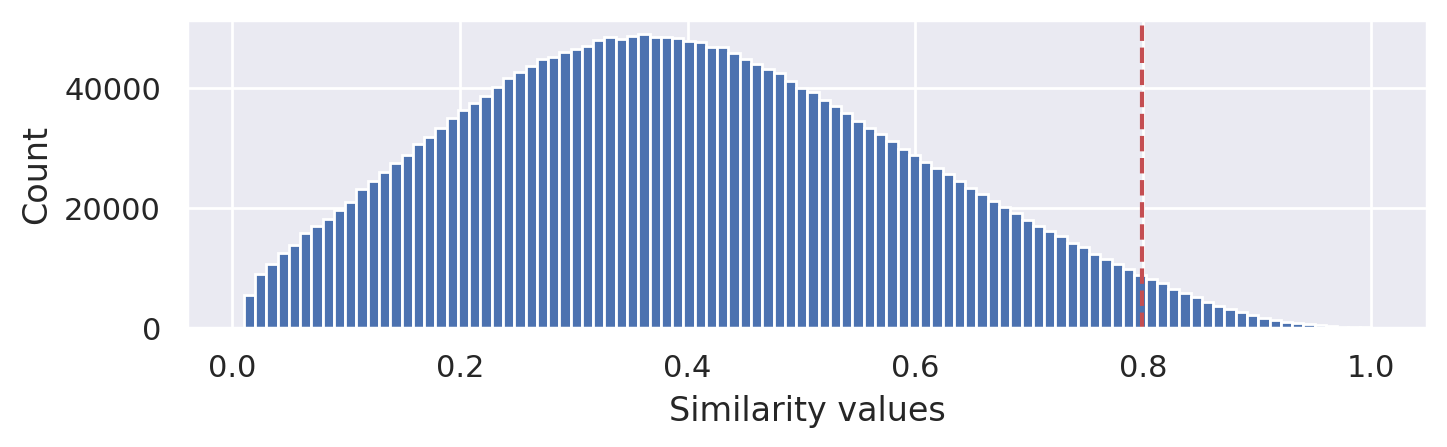

In [44]:
n_edges_per_node = 25

n_edges = n_edges_per_node * n_nodes
sorted_sim = np.sort(S.data)[::-1]
thr = sorted_sim[n_edges]

print(f"Threshold: {thr}")
print(f"Number of edges: {n_edges}")

plt.figure(figsize=(8, 2))
plt.hist(S.data, bins=100)
plt.axvline(thr, linestyle='--', color='r')
plt.xlabel('Similarity values')
plt.ylabel('Count')
plt.show()

In [45]:
S.data = np.where(S.data < thr, 0, S.data)
S.eliminate_zeros()

Plot graph and compute layout.

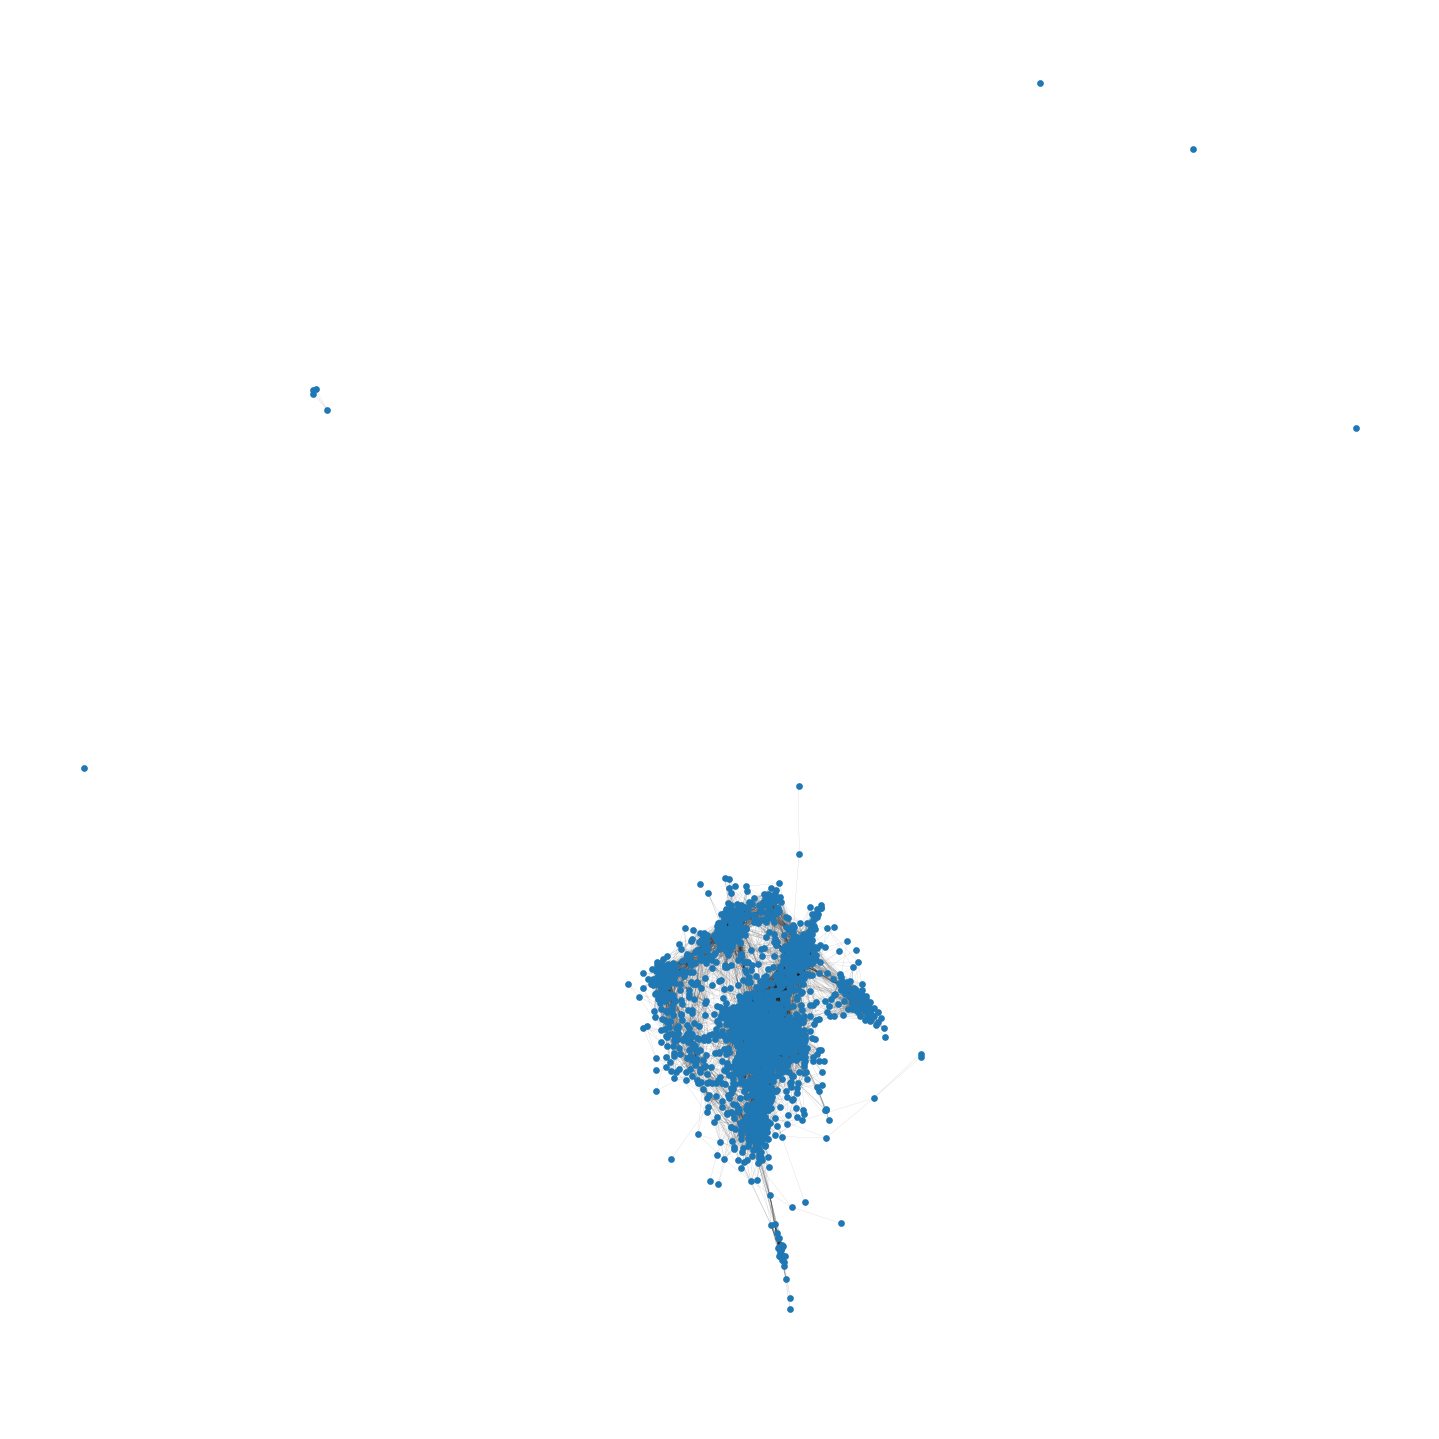

In [46]:
G = nx.from_scipy_sparse_array(S)
positions = nx.spring_layout(G, iterations=50, seed=0)

plt.figure(figsize=(7,7))
nx.draw(G, positions, node_size=2, width=0.02)

Find the largest connected component.

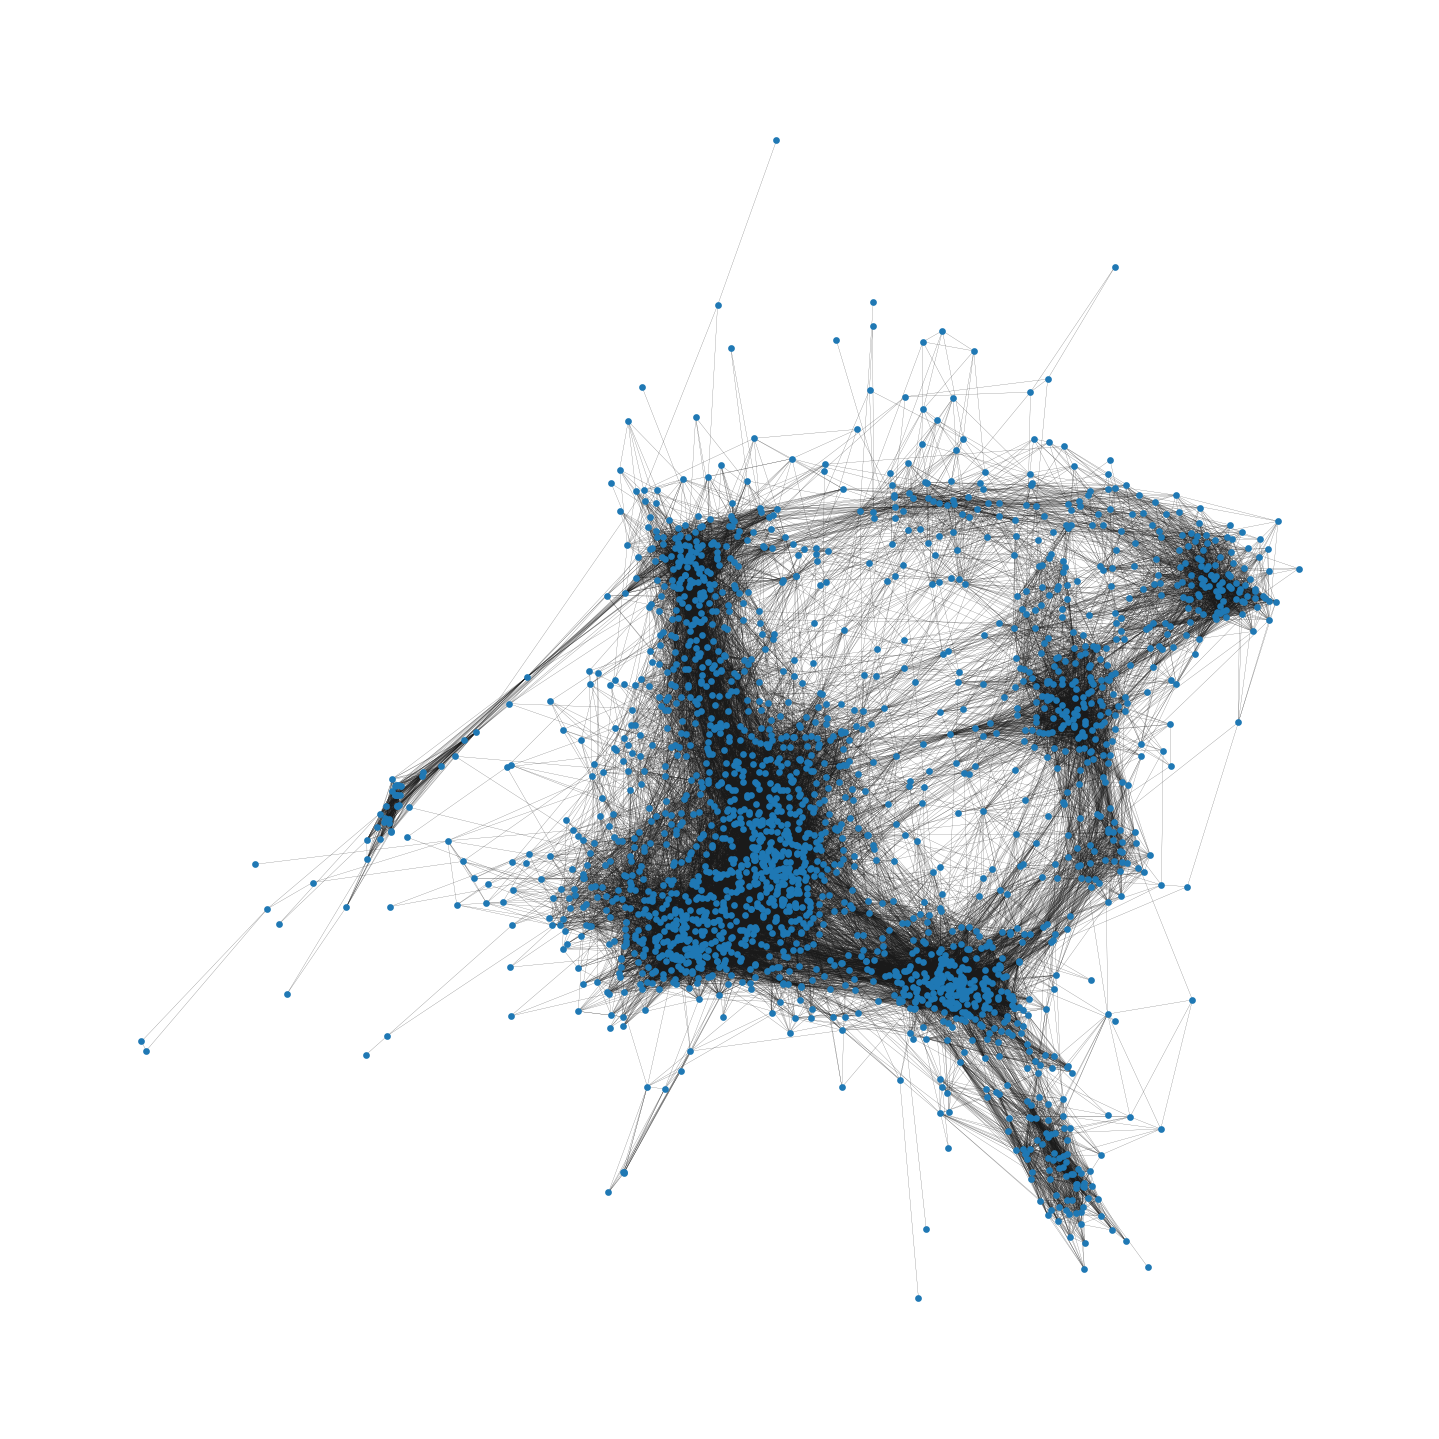

In [47]:
nodes_lcc = list(nx.connected_components(G))[0]

fig = plt.figure(figsize=(7, 7))
G_lcc = G.subgraph(nodes_lcc)
positions_lcc = nx.spring_layout(G_lcc, iterations=50, seed=0)

nx.draw(G_lcc, positions_lcc, node_size=2, width=0.06)
fig.show()

Community detection algorithm to explore semantic structure of corpus and similarities between documents.

In [48]:
C = nx.community.louvain_communities(G_lcc, seed=0)

# Metrics of the partition
modularity = nx.community.modularity(G_lcc, C)
coverage, performance = nx.community.partition_quality(G_lcc, C)

nc = len(C)
print(f"Number of communities: {nc}")
print(f"Modularity: {modularity}")
print(f"Coverage: {coverage}")
print(f"Performance: {performance}")

Number of communities: 12
Modularity: 0.7175539024558223
Coverage: 0.8551414221517314
Performance: 0.9011028116398032


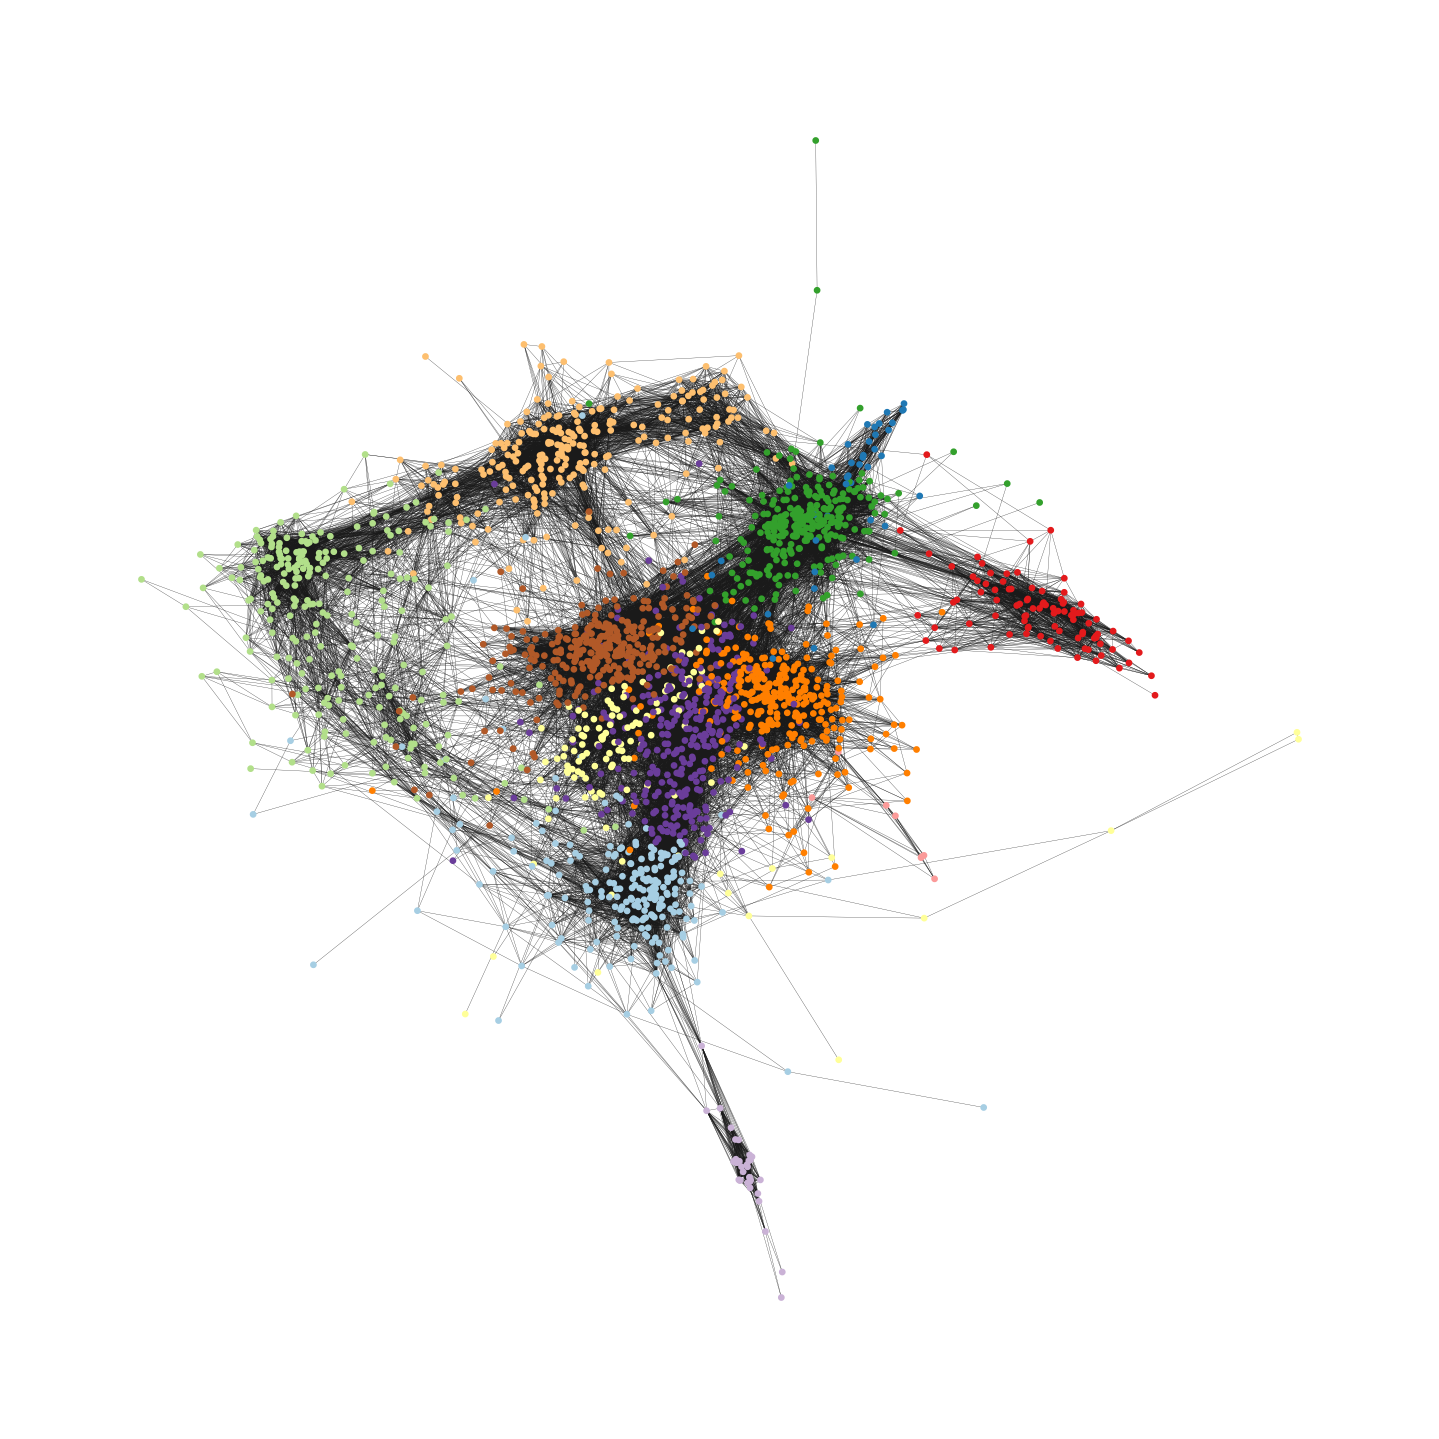

In [49]:
palette = sns.color_palette(palette="Paired", n_colors=nc)

node2comm = {n: 0 for n in G_lcc}
for i, com in enumerate(C):
    for node in list(com):
        node2comm[node] = i

# Map node attribute to rgb colors
node_colors = [palette[node2comm[n]] for n in G_lcc]

#  Draw graph
plt.figure(figsize=(7, 7))
nx.draw(G_lcc, positions, node_size=2, node_color=node_colors, width=0.1)

## **6. Extension Work**

In [ ]:
# TDOD